## Ensemble

In [ ]:
Voting - 서로 다른 모델 여러 개, 학습 데이터는 동일
         여러 모델의 결과를 집계 (hard voting - 개수, soft voting - 확률값의 평균)
         모델별로 가중치(weight)를 사용해서 서로 다른 권리를 부여할 수 있다

Bagging - 같은 모델 여러 개, 학습 데이터가 다름
          데이터 셋에서 - 일부 데이터를 sampling해서 학습데이터로 사용함
          데이터를 sampling을 부트스트랩(bootstrap)방식으로 함
           - 단순 임의 복원 추출 방식(중복 허용, 선택되지 않을 수 있음)
          모델간 서로 영향을 주지 않는 sampling과 학습이 이루어짐
          결과를 집계해서 최종 결과를 산출
          
Boosting - 순차적 학습
           데이터 셋에서 데이터를 sampling할  때 이전 모델의 학습결과를 사용해서 sampling을 함
           학습결과가 좋지 않은 sample에 대해 다시 학습 대상으로 사용될 확률을 높임

Stacking - 여러 개의 서로 다른 모델이 데이터셋에 대해 학습을 하여 결과를 만들어냄
           학습 결과를 가지고 다시 학습하는 모델 - 최종결과를 만들어냄 

## 1.함수 생성

In [19]:
# [1] get_classification_scores 함수 만들기
# accuracy, precision, recall, f1
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

def get_classification_scores(model, x_test, y_test):
    y_pred = model.predict(x_test)
    A = accuracy_score(y_test, y_pred)
    B = precision_score(y_test, y_pred)
    C = recall_score(y_test, y_pred)
    D = f1_score(y_test, y_pred)
    return [round(x, 4) for x in [A, B, C, D]]

In [18]:
# [2] get_regression_scores 함수 만들기
# r2_score, mae, mse, msle
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

def get_regression_scores(model, x_test, y_test):
    y_pred = model.predict(x_test)
    A = r2_score(y_test, y_pred)
    B = mae(y_test, y_pred)
    C = mse(y_test, y_pred)
    D = msle(y_test, y_pred)
    return [round(x, 4) for x in [A, B, C, D]]

In [17]:
# [3] make_data 함수 만들기
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

def make_data(data, kind='classification'):

    # 데이터를 X, y로 분리한다
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # 스케일링 처리
    X_scaled = StandardScaler().fit_transform(X)

    # train test 분리 (7.5:2.5), 층화추출, random_state=0
    stratify = y if kind=='classification' else None
    result = train_test_split(X_scaled,
                              y,
                              stratify=stratify,
                              random_state=0) 
    return result


In [16]:
# [4] make_classification_model 함수 만들기
def make_classification_model(name, model, data):
    # data 분리
    x_train, x_test, y_train, y_test = data

    # 모델 학습  
    model.fit(x_train, y_train)

    # train_scores, test_score 구하기
    train_scores = get_classification_scores(model, x_train, y_train)
    test_scores = get_classification_scores(model, x_test, y_test)

    # DataFrame으로 만들어 x_test, y_test 와 함께 반환하기
    index = ['name', 'model',
             'accuracy1', 'precision1', 'recall1', 'f1_1',
             'accuracy2', 'precision2', 'recall2', 'f1_2']
    data = [name, model] + train_scores + test_scores
    return pd.Series(data, index=index).to_frame().T

In [20]:
# [5] make_regression_model 함수 만들기
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

def make_regression_model(name, model, data):
    # 데이터 나누기
    x_train, x_test, y_train, y_test = data

    # 모델 학습  
    model.fit(x_train, y_train)

    # train_scores, test_score 구하기
    train_scores = get_regression_scores(model, x_train, y_train)
    test_scores = get_regression_scores(model, x_test, y_test)

    # DataFrame으로 만들어 x_test, y_test 와 함께 반환하기
    index = ['name', 'model',
             'r2_score1', 'mae1', 'mse1', 'msle1',
             'r2_score2', 'mae2', 'mse2', 'msle2']
    data = [name, model] + train_scores + test_scores
    return pd.Series(data, index=index).to_frame().T

## 2.위스콘신 유방암 진단(이진 분류)

### 2-1) 데이터 가져오기

In [ ]:
!git clone https://github.com/Soyoung-Yoon/data_05

Cloning into 'data_05'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [50]:
# [1] 암 데이터 가져오기
# 암 데이터를 가져와 cancer로 이름 지정
# make_data 를 사용한 data 분리 후 data_cancer 이름 지정
# target : ['malignant' 'benign']  : 악성(0), 양성(1)

import pandas as pd

cancer = pd.read_csv('./data_05/breast_cancer.csv')
cancer

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [52]:
X= cancer.drop(columns='class')
Y=cancer['class']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
A = train_test_split(X_scaled, Y, train_size=0.25, random_state=0, stratify=Y)
x_train, x_test, y_train, y_test = A
[x.shape for x in A]

[(142, 30), (427, 30), (142,), (427,)]

### 2-2) voting 참여 분류기 생성
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In [ ]:
# VotingClassifier의 사용법 확인
from sklearn.ensemble import VotingClassifier
VotingClassifier?

In [ ]:
# VotingRegressor의 사용법 확인
from sklearn.ensemble import VotingRegressor
VotingRegressor?

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
LogisticRegression?

In [37]:
# [2] Voting을 위한 다양한 모델 생성

import pandas as pd

# Voting을 위한 다양한 모델 생성
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

# 1. n_neighbors 를 각각 3, 5로 갖는 KNN 모델 두 개 만들기
# 2. max_iter=10000 인 LogisticRegression 모델 만들기
# 3. max_depth 를 각각 3, 5로 갖는 DecisionTree 모델 두 개 만들기
knn3 = KNeighborsClassifier(n_neighbors=3)
knn5 = KNeighborsClassifier(n_neighbors=5)
lr = LogisticRegression(max_iter=10000)
dt3 = DecisionTreeClassifier(max_depth=3)
dt5 = DecisionTreeClassifier(max_depth=5)

# estimators = [('knn3', knn3), ('knn5', knn5), ...]  와 같이 
# estimator의 목록 생성
names = ['knn3', 'knn5', 'lr', 'dt3', 'dt5']
estimator = [knn3, knn5, lr, dt3, dt5]
estimators = list(zip(names,estimator))
#print(estimators)

# Hard Voting 모델 생성
hard = VotingClassifier(estimators, voting='hard')

# Soft Voting 모델 생성
soft = VotingClassifier(estimators, voting='soft')

In [53]:
Tnames = names + ['hard', 'soft']
Testimator = estimator + [hard, soft]

train_score = []
test_score = []
for model in Testimator:
    model.fit(x_train, y_train)
    train_score.append(model.score(x_train, y_train)*100)
    test_score.append(model.score(x_test, y_test)*100)
#display(train_score, test_score)
temp = pd.DataFrame()
temp['train']=train_score
temp['test']=test_score
temp['diff']=temp['train']-temp['test']
temp.index = Tnames
temp.sort_values('diff')

,train,test,diff
lr,99.295775,97.423888,1.871887
knn5,97.183099,94.145199,3.037900
hard,99.295775,96.018735,3.277039
knn3,98.591549,94.847775,3.743774
soft,100.000000,92.974239,7.025761
dt3,100.000000,91.334895,8.665105
dt5,100.000000,90.632319,9.367681


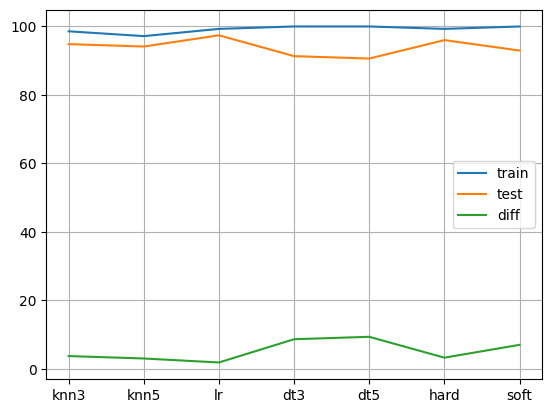

In [54]:
import matplotlib.pyplot as plt
temp.plot()
plt.grid(True)
plt.show()

In [ ]:
# [3] 각 모델을 make_classification_model 을 사용하여 학습 
Tnames = ['hard', 'soft'] + names
Testimators = [hard, soft] + estimator

# 반복문을 사용한 ensemble 및 단독 모델 성능 비교
result = []
for a, b in zip(Tnames, Testimators):
    r = make_classification_model(a, b, data_cancer)
    #display(r)
    result.append(r)
    
df = pd.concat(result, ignore_index=True)
df

In [ ]:
# [4] accuracy1, accuracy2, diff 구하기
df['diff'] = 

temp = df[['name', 'accuracy1', 'accuracy2', 'diff']]
# temp를 diff를 기준으로 오름차순 정렬


,name,accuracy1,accuracy2,diff
3,knn5,0.9836,0.951,0.0247
4,lr,0.9906,0.958,0.0258
0,hard,0.993,0.958,0.027
2,knn3,0.9883,0.951,0.0285
1,soft,0.9977,0.9441,0.0421
5,dt3,0.9765,0.9161,0.0487
6,dt5,1.0,0.9021,0.0795


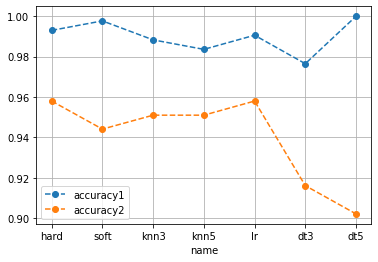

In [ ]:
# [5] accuracy 에 대한 선 그래프 그리기
import matplotlib.pyplot as plt

plt.grid()
plt.show()

### 2-3) 배깅(Bagging) 방식 - RandomForest
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [57]:
from sklearn.ensemble import RandomForestClassifier
# [6] cancer 데이터, RandomForestClassifier를 사용하여 학습하고 성능을 확인한다
# RandomForestClassifier의 경우 max_depth=4, random_state=0 사용


model = RandomForestClassifier(max_depth=4, random_state=0)
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(1.0, 0.9250585480093677)

### 2-4) 부스팅(Boosting) 방식 : GradientBoosting

In [56]:
# [7] cancer 데이터, GradientBoostingClassifier를 사용하여 학습하고 성능을 확인한다
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, subsample=0.7, random_state=0)
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(1.0, 0.9414519906323185)

### 2-5) Stacking 방식 : StackingClassifier

In [ ]:
from sklearn.ensemble import StackingClassifier
StackingClassifier?

In [63]:
from sklearn.ensemble import StackingClassifier

# [8] RandomForestClassifier, GradientBoostingClassifier 를 estimators로 사용하고
# LogisticRegression을 final_estimator로 사용한다
# 이때, estimator 각각에 이름은 'rf', 'gb'로 사용한다
name = ['rf', 'gb']
estimator = [RandomForestClassifier(), GradientBoostingClassifier()]
estimators = list(zip(name, estimator))

model = StackingClassifier(estimators, LogisticRegression())
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(1.0, 0.9227166276346604)

### 2-6) XGBOOST(Extream Gradient Boost)

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### XGBOOST 분류
- https://xgboost.readthedocs.io/en/latest/index.html
- https://xgboost.readthedocs.io/en/latest/python/python_api.html

In [ ]:
from xgboost import XGBClassifier
XGBClassifier?

In [66]:
from xgboost import XGBClassifier

# [9] XGBClassifier 를 사용하여 model을 만들고 학습시킨 뒤 성능을 확인한다
#   n_estimators=400, learning_rate=0.1, max_depth=3, 
#   use_label_encoder=False (Deprecated) eval_metric='logloss' 을 사용한다
model = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(1.0, 0.9227166276346604)

- https://hwi-doc.tistory.com/entry/%EC%9D%B4%ED%95%B4%ED%95%98%EA%B3%A0-%EC%82%AC%EC%9A%A9%ED%95%98%EC%9E%90-XGBoost

#### XGBOOST 회귀 

In [71]:
from xgboost import XGBRegressor
import pandas as pd

# [10] 보스톤 데이터 준비, 데이터 분리하여 data_boston 생성
boston = pd.read_csv('data_05/boston.csv')
X= boston.drop(columns='PRICE')
Y=boston['PRICE']
scaler = StandardScaler()
X_scaled=scaler.fit_transform(X)
A=train_test_split(X_scaled, Y, test_size=0.25, random_state=0)
x_train, x_test, y_train, y_test = A

# [11] XGBRegressor 를 사용하여 model을 만들고 학습시킨 뒤 성능을 확인한다
#   다음 값을 사용한다
#   n_estimators=1000, learning_rate=0.2, max_depth=3,
#   objective ='reg:squarederror'

model = XGBRegressor(n_estimators=1000, learning_rate=0.2, max_depth=3)
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(0.9999998554190542, 0.7788699827725095)

### 2-7) lightGBM

In [67]:
!pip install lightgbm

#### ligthGBM  분류
- https://lightgbm.readthedocs.io/en/latest/
- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier

In [69]:
from lightgbm import LGBMClassifier
# [12] data_cancer, LGBMClassifier를 사용하여 학습 후 성능 출력
# n_estimators=100으로 사용한다 (여러 가지로 변경해 볼 것)
model = LGBMClassifier(n_estimators=100)
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(1.0, 0.9414519906323185)

#### ligthGBM  회귀

In [74]:
from lightgbm import LGBMRegressor

boston = pd.read_csv('data_05/boston.csv')
X= boston.drop(columns='PRICE')
Y=boston['PRICE']
scaler = StandardScaler()
X_scaled=scaler.fit_transform(X)
A=train_test_split(X_scaled, Y, test_size=0.25, random_state=0)
x_train, x_test, y_train, y_test = A

# [13] LGBMRegressor를 사용하여 학습 후 성능 출력
# n_estimators=100로 사용한다 (여러 가지로 변경해 볼 것, 개수, max_depth)

model = LGBMRegressor(n_estimators=1000, max_depth=3)
model.fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(0.9976126018855925, 0.7713717904317868)

In [ ]:
# GridSearchCV를 사용한 hyper parameter 최적화 (ML_01에서 학습)

In [ ]:
# 3개
#n_estimators= 100, 200, 300, 500, 1000  (5가지)
#leaning_rate = 0.01, 0.05, 0.1, 1, 10 (5가지)
#max_depth = 3, 4, 5, 6 (4가지)
#5 * 5 * 4 만큼 실행해야 가장 좋은 hyper parameter를 찾을 수 있음


In [ ]:
# GridSearch는 모든 조합에 대해 실행해봄'
# CV(Cross Validation)
from sklearn.model_selection import GridSearchCV

